# Analysis and statistics of the evaluation results from "On the use of LLMs to Explain Dynamic Access Control Policies" (OrBAC)

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [106]:
# prompt: display all columns when printing a dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

## Data import and evaluation preparation

In [107]:
# List of file paths
file_paths = [
    "/content/output_DeepSeek-R1-Distill-Qwen-1.5B.csv",
    "/content/output_DeepSeek-R1-Distill-Qwen-7B.csv",
    "/content/output_Llama-3.2-3B-Instruct.csv",
    "/content/output_Llama-3.2-3B.csv",
    "/content/output_gemma-2-9b-it.csv"
]
file_paths = [
    "results/output_DeepSeek-R1-Distill-Qwen-1.5B_new.csv",
    "results/output_DeepSeek-R1-Distill-Qwen-7B_new.csv",
    "results/output_Llama-3.2-3B-Instruct_new.csv",
    "results/output_Llama-3.2-3B_new.csv",
    #"results/output_gemma-2-2b-it_new.csv",
    "results/output_gemma-2-9b-it_new.csv",
    "results/output_gemma-2-9b_new.csv"
]

In [108]:
# using an alias for models
model_names = {
	"DeepSeek-R1-Distill-Qwen-1.5B" : "deepseek-r1:1.5B",
	"DeepSeek-R1-Distill-Qwen-7B" : "deepseek-r1:7B",
	"Llama-3.2-3B" : "llama-3.2-3B",
	"Llama-3.2-3B-Instruct" : "llama-3.2-3B(IT)",
	"gemma-2-9b" : "gemma-2-9B",
	"gemma-2-9b-it" : "gemma-2-9B(IT)",
}

In [109]:
# Create an empty list to store DataFrames
dfs = []

for file_path in file_paths:
    # Read the CSV file
    df = pd.read_csv(file_path, sep=";", header=0)

    # Extract model name from filename (remove path, 'output_' prefix, and .csv extension)
    model_name = os.path.basename(file_path).replace('output_', '').replace('.csv', '').replace('_new', '')

    # Add model column
    df['model'] = model_names[model_name]

    # Append to list
    dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(dfs, ignore_index=True)

In [110]:
combined_df.head(1)

,trial,subject,action,obj,outcome,decision,logical_explanations,prompt_text,prompt_size,answer_size,answer,combined_score,coverage,completness,correctness,clarity,hallucination,grammar_score,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,coleman_liau_index,ari,model
0,0,Bob,edit,report1,True,**The Decision:** The outcome of the logical i...,"(secondee, secondment) > (staff_member, defaul...",1. **Overall Logic:** Explain the condition un...,565,21,**Structure:**\n- 1. **Decision Rule**: [Rule]...,0.228534,0.056229,0.056229,0.281982,0.103943,0.355713,1.0,73.85,4.5,9.07,0.0,5.27,16.9,deepseek-r1:1.5B


In [111]:
columns_to_analyze = ['coverage', 'completness', 'correctness', 'clarity', 'hallucination', 'grammar_score',]

## Cumulative results of interactions (trials)

In [112]:
def get_cumulative_by_model(df, threshold=0.6, columns_to_analyze=None):
    if columns_to_analyze is None:
        columns_to_analyze = []  # You should provide your columns here

    count_above = lambda df: (df > threshold).sum()

    # Group by model first, then by trial
    grouped = df.groupby(['model', 'trial'])

    # Compute counts per trial within each model
    counts_per_trial = grouped[columns_to_analyze].apply(count_above)

    # Compute cumulative sums within each model
    cumulative_numerator = counts_per_trial.groupby(level=0).cumsum()

    # Compute cumulative percentage
    cumulative_results = {}

    for model in df['model'].unique():
        # Get the size of trial 0 for this model
        trial_0_size = len(df[(df['model'] == model) & (df['trial'] == df['trial'].min())])

        # Calculate percentage for this model's data
        model_data = cumulative_numerator.loc[model]
        model_percentage = (model_data / trial_0_size * 100).round(1)
        cumulative_results[model] = model_percentage

    # Combine all models' results
    cumulative_results_df = pd.concat(cumulative_results)

    return cumulative_results_df

In [113]:
cumulative_results_df = get_cumulative_by_model(combined_df, columns_to_analyze=columns_to_analyze)

In [114]:
cumulative_results_df = cumulative_results_df.clip(upper=100)

In [115]:
cumulative_results_df

coverage  completness  correctness  clarity  \
                 trial                                                
deepseek-r1:1.5B 0          12.4          9.9         43.8     92.6   
                 1          27.3         20.7         74.4    100.0   
                 2          31.4         23.1         96.7    100.0   
                 3          36.4         27.3        100.0    100.0   
deepseek-r1:7B   0          37.9         29.8         89.5     93.5   
                 1          51.6         41.1        100.0    100.0   
                 2          60.5         48.4        100.0    100.0   
                 3          70.2         52.4        100.0    100.0   
llama-3.2-3B(IT) 0          56.2         39.7         85.1     95.9   
                 1          73.6         52.1        100.0    100.0   
                 2          83.5         58.7        100.0    100.0   
                 3          87.6         61.2        100.0    100.0   
llama-3.2-3B     0          68.3         52.5         92.5     85.0   
                 1          80.0         62.5        100.0    100.0   
                 2          92.5         71.7        100.0    100.0   
                 3         100.0         79.2        100.0    100.0   
gemma-2-9B(IT)   0          30.0         17.5         97.5     99.2   
                 1          51.7         30.8        100.0    100.0   
                 2          60.0         35.8        100.0    100.0   
                 3          65.8         40.8        100.0    100.0   
gemma-2-9B       0          48.3         34.2         90.8     89.2   
                 1          70.0         49.2        100.0    100.0   
                 2          76.7         53.3        100.0    100.0   
                 3          83.3         57.5        100.0    100.0   

                        hallucination  grammar_score  
                 trial                                
deepseek-r1:1.5B 0                8.3          100.0  
                 1               14.9          100.0  
                 2               23.1          100.0  
                 3               28.9          100.0  
deepseek-r1:7B   0               18.5          100.0  
                 1               33.1          100.0  
                 2               40.3          100.0  
                 3               52.4          100.0  
llama-3.2-3B(IT) 0                8.3           96.7  
                 1               14.9          100.0  
                 2               21.5          100.0  
                 3               24.0          100.0  
llama-3.2-3B     0               36.7           98.3  
                 1               49.2          100.0  
                 2               60.0          100.0  
                 3               68.3          100.0  
gemma-2-9B(IT)   0               27.5          100.0  
                 1               48.3          100.0  
                 2               65.0          100.0  
                 3               73.3          100.0  
gemma-2-9B       0               29.2          100.0  
                 1               44.2          100.0  
                 2               52.5          100.0  
                 3               60.8          100.0

## Evaluation of Nbr of succesful interactions per model (score > 0.6) + (cumulative results)

In [116]:
markers = {
    "deepseek-r1:1.5B" : 'p',
    "deepseek-r1:7B": '^',
    "gemma-2-9B" : '*',
    "gemma-2-9B(IT)" : '<',
    "llama-3.2-3B" : 'o',
    "llama-3.2-3B(IT)" : 'X'
}
# More markers: 'h', 's', 'v', '>', 'H', 'D', 'd', 'P'

In [117]:
filtered_df = combined_df.copy()
# Your existing filtering code
filtered_df = filtered_df[
    (filtered_df['coverage'] > 0.6) &
    (filtered_df['correctness'] > 0.6) &
    (filtered_df['clarity'] > 0.6)
]

# Create a complete MultiIndex with all model-trial combinations
all_models = combined_df['model'].unique()
all_trials = range(0, 4)  # Trials 1-4
full_index = pd.MultiIndex.from_product([all_models, all_trials], names=['model', 'trial'])

# Group and count, then reindex to include all possible combinations
result = (filtered_df.groupby(['model', 'trial'])
          .size()
          .reindex(full_index, fill_value=0)
          .unstack(level='model'))

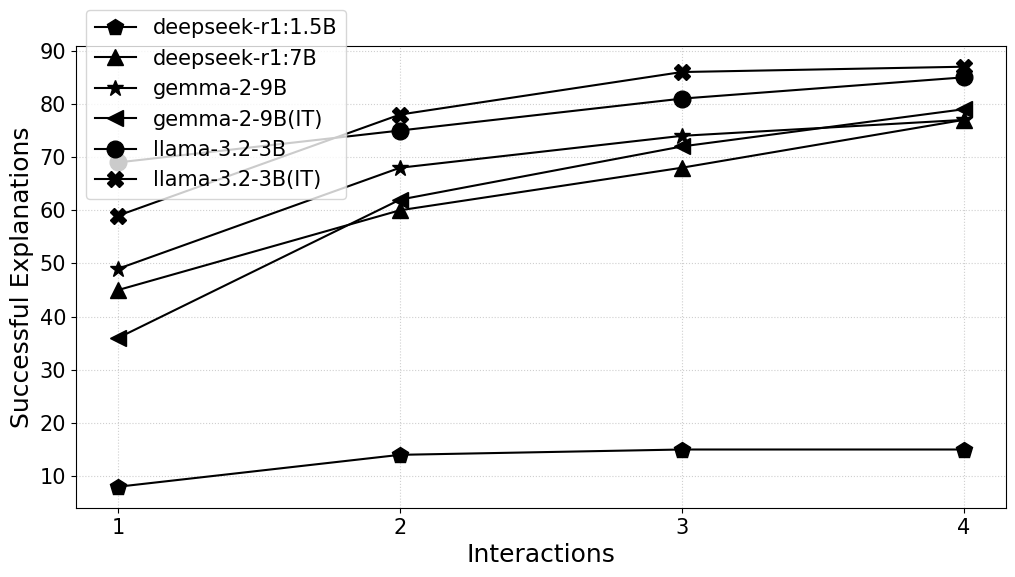

In [118]:
# Plotting code
fig, ax = plt.subplots(figsize=(12, 6))

for i, model in enumerate(result.columns):
    # Calculate cumulative sum
    cumulative_data = result[model].cumsum()
    marker = markers[model]
    ax.plot(cumulative_data.index + 1, cumulative_data.values,
            label=model, marker=marker, color='black', markersize=12, linestyle='-')

ax.set_xlabel('Interactions', size=18)
ax.set_ylabel('Successful Explanations', size=18)
#ax.set_title('Cumulative Number of Rows by Trial Number for Each Model')
ax.legend(loc='upper left', fontsize=15, bbox_to_anchor=(-0.00, 1.1), ncol=1)
# Set x-axis ticks to show whole numbers (1, 2, 3, 4)
ax.set_xticks(range(1, 5))
ax.grid(True, linestyle=':', alpha=0.6)
# Increase tick label sizes
ax.tick_params(axis='x', labelsize=15)  # Larger x-axis ticks
ax.tick_params(axis='y', labelsize=15)  # Larger y-axis ticks
plt.show()

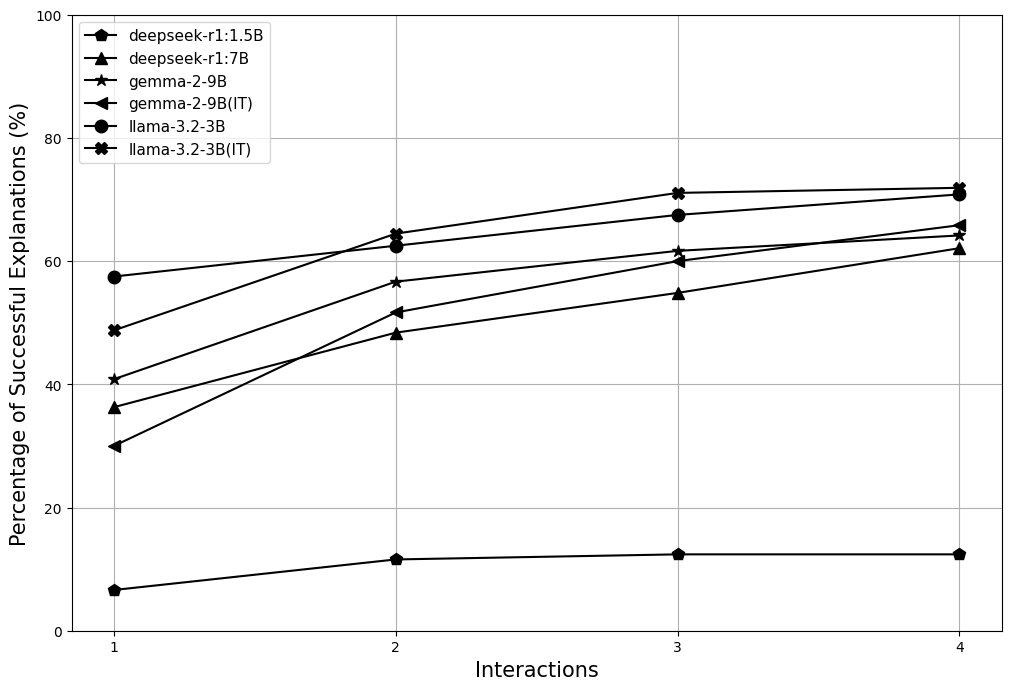

In [119]:
filtered_df = combined_df.copy()
# Your existing filtering code
filtered_df = filtered_df[
    (filtered_df['coverage'] > 0.6) &
    (filtered_df['correctness'] > 0.6) &
    (filtered_df['clarity'] > 0.6)
]

# Create a complete MultiIndex with all model-trial combinations
all_models = combined_df['model'].unique()
all_trials = range(0, 4)  # Trials 0-3 (we'll +1 later)
full_index = pd.MultiIndex.from_product([all_models, all_trials], names=['model', 'trial'])

# Group and count, then reindex to include all possible combinations
result = (filtered_df.groupby(['model', 'trial'])
          .size()
          .reindex(full_index, fill_value=0)
          .unstack(level='model'))

# Get initial number of rows per model (trial=0 counts from original data)
initial_counts = combined_df[combined_df['trial'] == 0].groupby('model').size()

# Plotting code
fig, ax = plt.subplots(figsize=(12, 8))

for i, model in enumerate(result.columns):
    if model in initial_counts:  # Only plot models that have trial=0 data
        # Calculate cumulative percentage using initial count as denominator
        cumulative_count = result[model].cumsum()
        cumulative_percentage = (cumulative_count / initial_counts[model]) * 100
        marker = markers[model]
        ax.plot(cumulative_percentage.index + 1, cumulative_percentage.values,
                label=model, marker=marker, color='black', markersize=9, linestyle='-')

ax.set_xlabel('Interactions', size=15)
ax.set_ylabel('Percentage of Successful Explanations (%)', size=15)
ax.legend(loc='upper left', fontsize=11)
ax.set_xticks(range(1, 5))
ax.set_ylim(0, 100)  # Ensure percentage scale goes from 0-100%
ax.grid(True)
plt.show()

## Evaluation of change between trials (Delta interaction)

### Average metric change between trials

In [206]:
# Step 1: Identify rows needing retry (any score < 0.6)
combined_df['needs_retry'] = (combined_df['coverage'] < 0.6) | (combined_df['correctness'] < 0.6) | (combined_df['clarity'] < 0.6)

# Step 2: Calculate trial pair differences
def calculate_improvements(metric):
  results = []
  for model in combined_df['model'].unique():
      model_data = combined_df[combined_df['model'] == model]

      for prev_trial, current_trial in [(1,2), (2,3), (3,4)]:
          # Get previous trial data (only rows needing retry)
          prev_data = model_data[(model_data['trial'] == prev_trial-1) & (model_data['needs_retry'])]

          # Get current trial data (all rows)
          current_data = model_data[model_data['trial'] == current_trial-1]

          if metric == 'mean':
                prev_avg = prev_data[['coverage', 'correctness', 'clarity']].mean()
                current_avg = current_data[['coverage', 'correctness', 'clarity']].mean()
          elif metric == 'median':
                prev_avg = prev_data[['coverage', 'correctness', 'clarity']].median()
                current_avg = current_data[['coverage', 'correctness', 'clarity']].median()

          # Calculate differences
          diff = current_avg - prev_avg

          results.append({
              'model': model,
              'trial_pair': f"{prev_trial}-{current_trial}",
              'coverage_diff': diff['coverage'],
              'correctness_diff': diff['correctness'],
              'clarity_diff': diff['clarity'],
              'n_prev': len(prev_data),
              'n_current': len(current_data)
          })
  return pd.DataFrame(results)

In [207]:
mean_diff = calculate_improvements(metric='mean')
median_diff = calculate_improvements(metric='median')

In [208]:
print("Mean Differences:")
mean_diff.pivot(index='trial_pair', columns='model')

Mean Differences:


coverage_diff                                           \
model      deepseek-r1:1.5B deepseek-r1:7B gemma-2-9B gemma-2-9B(IT)   
trial_pair                                                             
1-2                 0.03715       0.071123   0.155185       0.148643   
2-3                -0.06829       0.064807  -0.040522       0.047498   
3-4                 0.03997       0.122851   0.067207       0.069475   

                                         correctness_diff                 \
model      llama-3.2-3B llama-3.2-3B(IT) deepseek-r1:1.5B deepseek-r1:7B   
trial_pair                                                                 
1-2           -0.006992         0.050583        -0.088568      -0.005140   
2-3            0.029687         0.123793        -0.056474      -0.018910   
3-4            0.010491        -0.008786        -0.002103      -0.016522   

                                                                    \
model      gemma-2-9B gemma-2-9B(IT) llama-3.2-3B llama-3.2-3B(IT)   
trial_pair                                                           
1-2         -0.028584      -0.085481    -0.040378         0.001944   
2-3          0.032208       0.011938     0.056042        -0.001851   
3-4          0.014487       0.072075    -0.023267         0.003203   

               clarity_diff                                           \
model      deepseek-r1:1.5B deepseek-r1:7B gemma-2-9B gemma-2-9B(IT)   
trial_pair                                                             
1-2               -0.059089      -0.001912  -0.020528      -0.041867   
2-3               -0.013527      -0.026366  -0.099949      -0.038317   
3-4               -0.019349       0.006327  -0.080998       0.019305   

                                                   n_prev                 \
model      llama-3.2-3B llama-3.2-3B(IT) deepseek-r1:1.5B deepseek-r1:7B   
trial_pair                                                                 
1-2            0.024060        -0.045951              113             79   
2-3           -0.064962        -0.055118              106             64   
3-4           -0.021601        -0.033469              106             56   

                                                                    \
model      gemma-2-9B gemma-2-9B(IT) llama-3.2-3B llama-3.2-3B(IT)   
trial_pair                                                           
1-2                71             84           51               62   
2-3                51             58           45               42   
3-4                45             47           39               34   

                  n_current                                           \
model      deepseek-r1:1.5B deepseek-r1:7B gemma-2-9B gemma-2-9B(IT)   
trial_pair                                                             
1-2                     112             79         70             84   
2-3                     107             64         51             57   
3-4                     103             53         45             47   

                                          
model      llama-3.2-3B llama-3.2-3B(IT)  
trial_pair                                
1-2                  51               61  
2-3                  45               42  
3-4                  39               34

In [209]:
print("Median Differences:")
median_diff.pivot(index='trial_pair', columns='model')

Median Differences:


coverage_diff                                           \
model      deepseek-r1:1.5B deepseek-r1:7B gemma-2-9B gemma-2-9B(IT)   
trial_pair                                                             
1-2                0.047460      -0.000137   0.181488       0.137428   
2-3               -0.072901       0.010138  -0.098984       0.023153   
3-4                0.042116       0.169729   0.088074       0.012629   

                                         correctness_diff                 \
model      llama-3.2-3B llama-3.2-3B(IT) deepseek-r1:1.5B deepseek-r1:7B   
trial_pair                                                                 
1-2           -0.020549         0.070903        -0.124390      -0.018555   
2-3            0.021179         0.086803        -0.044067      -0.044189   
3-4           -0.063334         0.004496         0.009399      -0.069824   

                                                                    \
model      gemma-2-9B gemma-2-9B(IT) llama-3.2-3B llama-3.2-3B(IT)   
trial_pair                                                           
1-2         -0.020996      -0.037354     0.035645        -0.028076   
2-3          0.043945       0.018066    -0.014160        -0.030762   
3-4          0.032227      -0.000488     0.010742         0.010742   

               clarity_diff                                           \
model      deepseek-r1:1.5B deepseek-r1:7B gemma-2-9B gemma-2-9B(IT)   
trial_pair                                                             
1-2               -0.075439       0.004395  -0.026855      -0.031982   
2-3                0.020508      -0.009521  -0.158691      -0.012939   
3-4               -0.016602      -0.027588  -0.204834       0.007812   

                                                   n_prev                 \
model      llama-3.2-3B llama-3.2-3B(IT) deepseek-r1:1.5B deepseek-r1:7B   
trial_pair                                                                 
1-2            0.087402        -0.068604              113             79   
2-3           -0.104004        -0.020264              106             64   
3-4           -0.118164        -0.060303              106             56   

                                                                    \
model      gemma-2-9B gemma-2-9B(IT) llama-3.2-3B llama-3.2-3B(IT)   
trial_pair                                                           
1-2                71             84           51               62   
2-3                51             58           45               42   
3-4                45             47           39               34   

                  n_current                                           \
model      deepseek-r1:1.5B deepseek-r1:7B gemma-2-9B gemma-2-9B(IT)   
trial_pair                                                             
1-2                     112             79         70             84   
2-3                     107             64         51             57   
3-4                     103             53         45             47   

                                          
model      llama-3.2-3B llama-3.2-3B(IT)  
trial_pair                                
1-2                  51               61  
2-3                  45               42  
3-4                  39               34

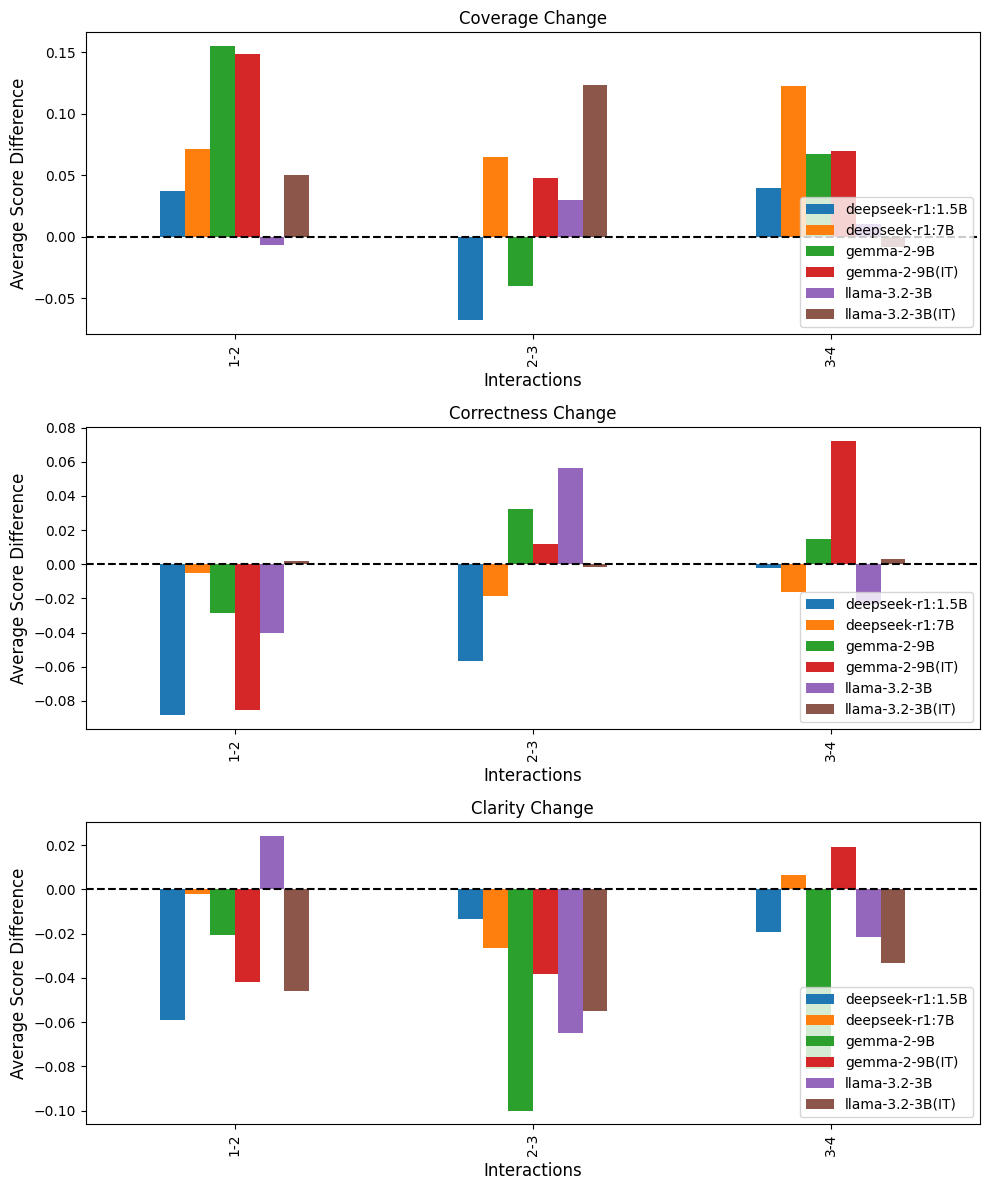

In [210]:
# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, metric in enumerate(['coverage', 'correctness', 'clarity']):
    metric_df = mean_diff.pivot(index='trial_pair', columns='model', values=f'{metric}_diff')
    metric_df.plot(kind='bar', ax=axes[i], title=f'{metric.capitalize()} Change')
    axes[i].axhline(0, color='black', linestyle='--')
    axes[i].set_ylabel('Average Score Difference', size=12)
    axes[i].set_xlabel('Interactions', size=12)
    axes[i].legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

### Median metric change between trials

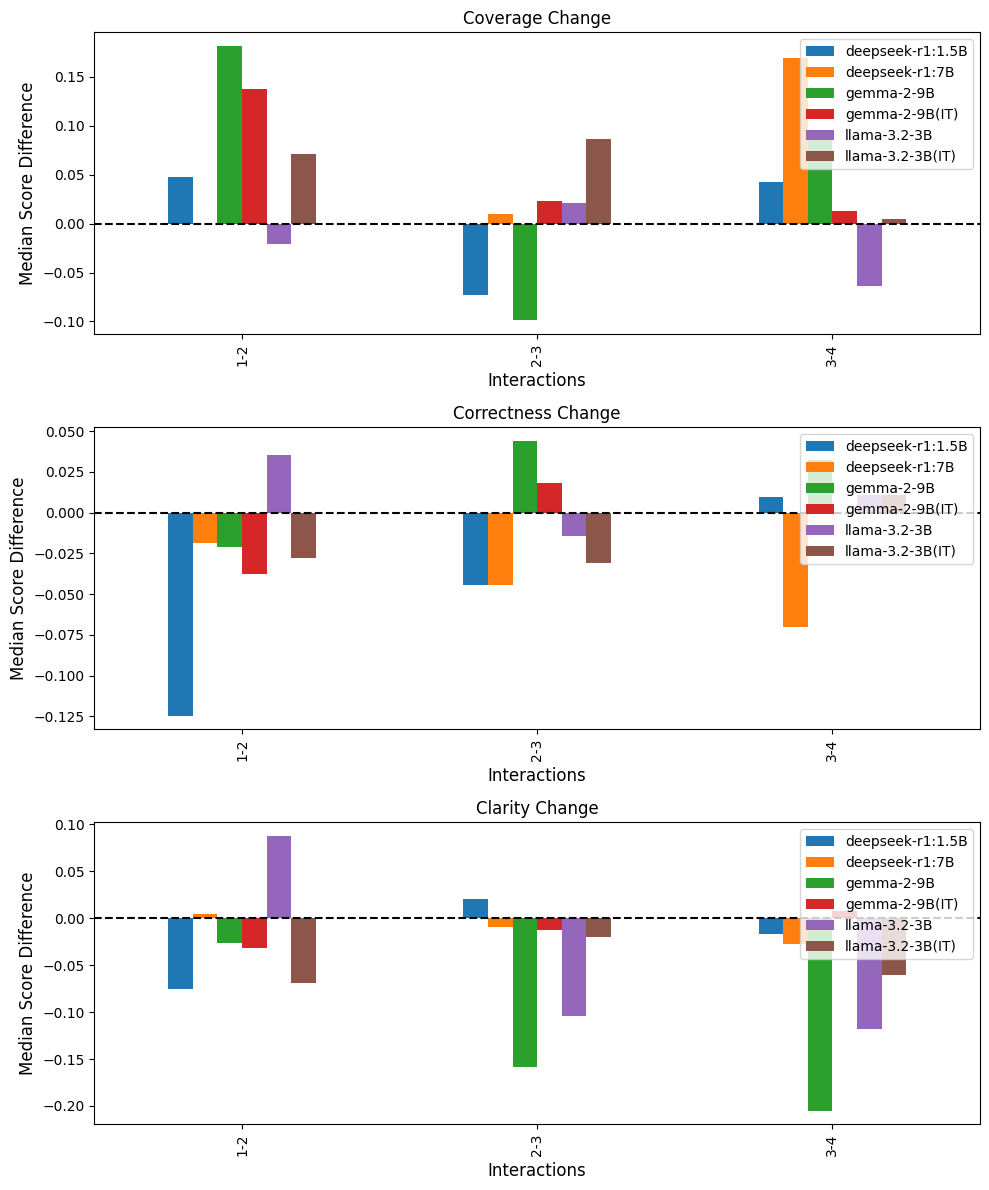

In [211]:
# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, metric in enumerate(['coverage', 'correctness', 'clarity']):
    metric_df = median_diff.pivot(index='trial_pair', columns='model', values=f'{metric}_diff')
    metric_df.plot(kind='bar', ax=axes[i], title=f'{metric.capitalize()} Change')
    axes[i].axhline(0, color='black', linestyle='--')
    axes[i].set_ylabel('Median Score Difference', size=12)
    axes[i].set_xlabel('Interactions', size=12)
    axes[i].legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

### Average metric change between trials (no colors B&W for paper)

In [212]:
# Define hatch patterns for each model (simpler than markers)
model_hatches = {
    "deepseek-r1:1.5B" : '+++',
    "deepseek-r1:7B": '///',
    "gemma-2-9B" : '***',
    "gemma-2-9B(IT)" : '---',
    "llama-3.2-3B" : '...',
    "llama-3.2-3B(IT)" : 'xxx'
}

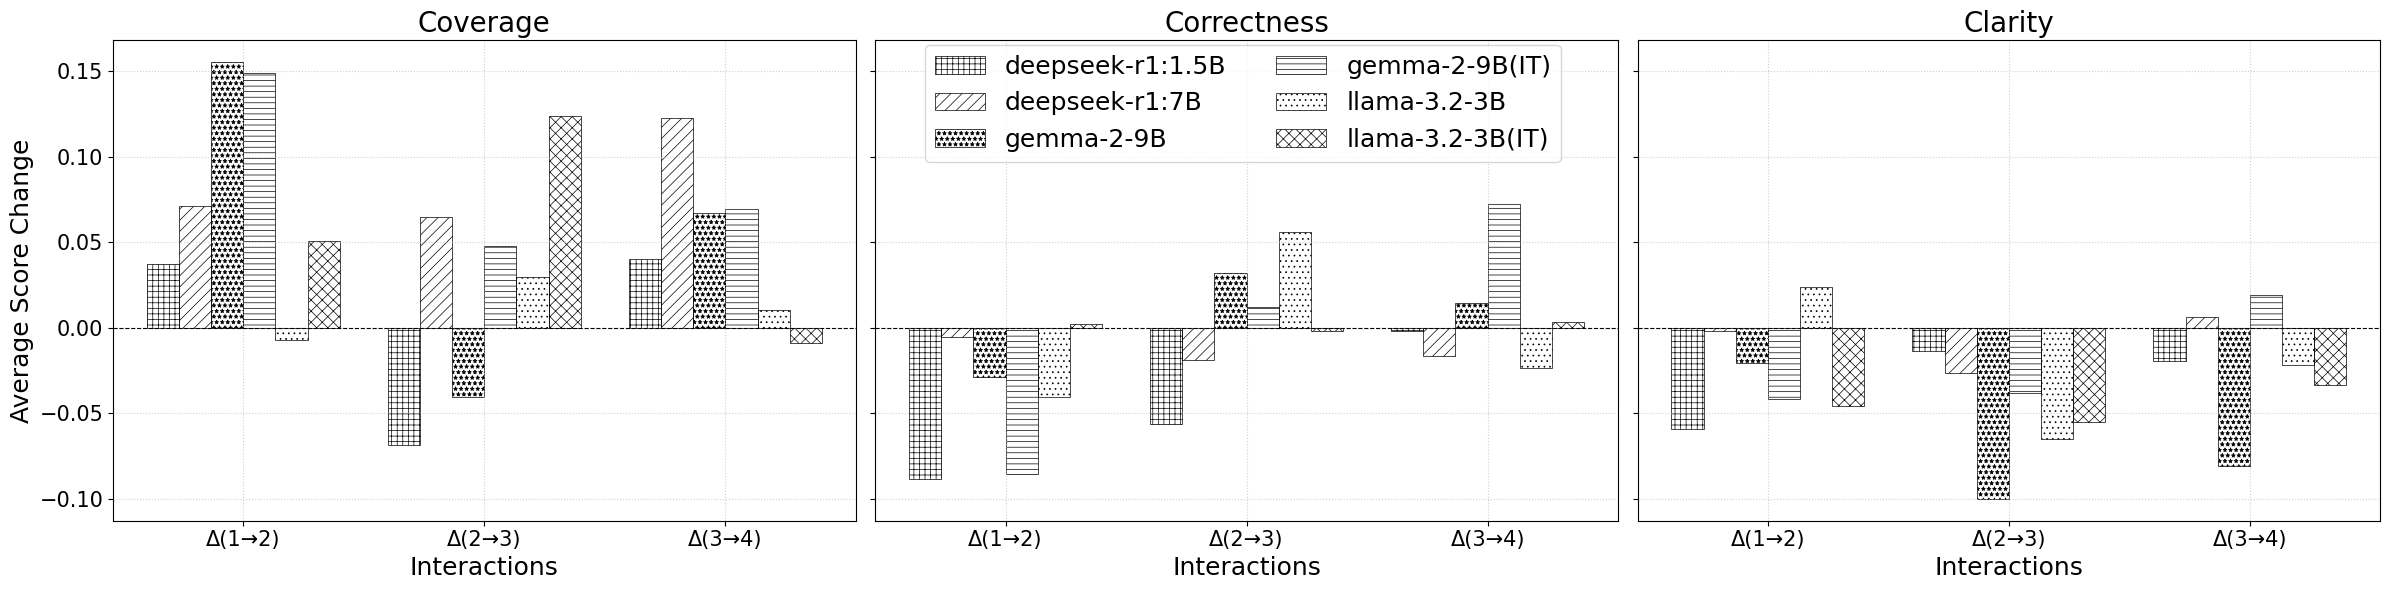

In [213]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

for i, metric in enumerate(['coverage', 'correctness', 'clarity']):
    metric_df = mean_diff.pivot(index='trial_pair', columns='model', values=f'{metric}_diff')

    # Position bars side-by-side
    n_models = len(metric_df.columns)
    bar_width = 0.8 / n_models  # Dynamic width based on model count
    x_pos = np.arange(len(metric_df.index))  # Trial pairs (0-1, 1-2, etc.)

    for j, model in enumerate(metric_df.columns):
        axes[i].bar(
            x_pos + j * bar_width,  # Offset each model's bars
            metric_df[model],
            width=bar_width,
            label=model,
            hatch=model_hatches.get(model, '....'),  # Fallback to dots
            edgecolor='black',
            fill=False,  # No fill (pure patterns)
            linewidth=0.5  # Finer bar edges
        )

    # Formatting
    axes[i].set_title(f'{metric.capitalize()}', size=20)
    axes[i].axhline(0, color='black', linestyle='--', linewidth=0.8)
    if i == 0:
        axes[i].set_ylabel('Average Score Change', size=18)
    axes[i].set_xlabel('Interactions', size=18)
    axes[i].set_xticks(x_pos + bar_width * (n_models - 1) / 2)  # Center labels
    axes[i].set_xticklabels([f"Δ({pair.replace('-', '→')})" for pair in metric_df.index])

    axes[i].grid(True, linestyle=':', alpha=0.6)

# Increase tick label sizes
for ax in axes:
    ax.tick_params(axis='x', labelsize=15)  # Larger x-axis ticks
    ax.tick_params(axis='y', labelsize=15)  # Larger y-axis ticks

plt.rcParams['hatch.linewidth'] = 0.5 
plt.tight_layout()
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=2, fontsize=18, bbox_to_anchor=(0.52, 0.82)) #ncol=len(labels) 
plt.show()

### Median metric change between trials

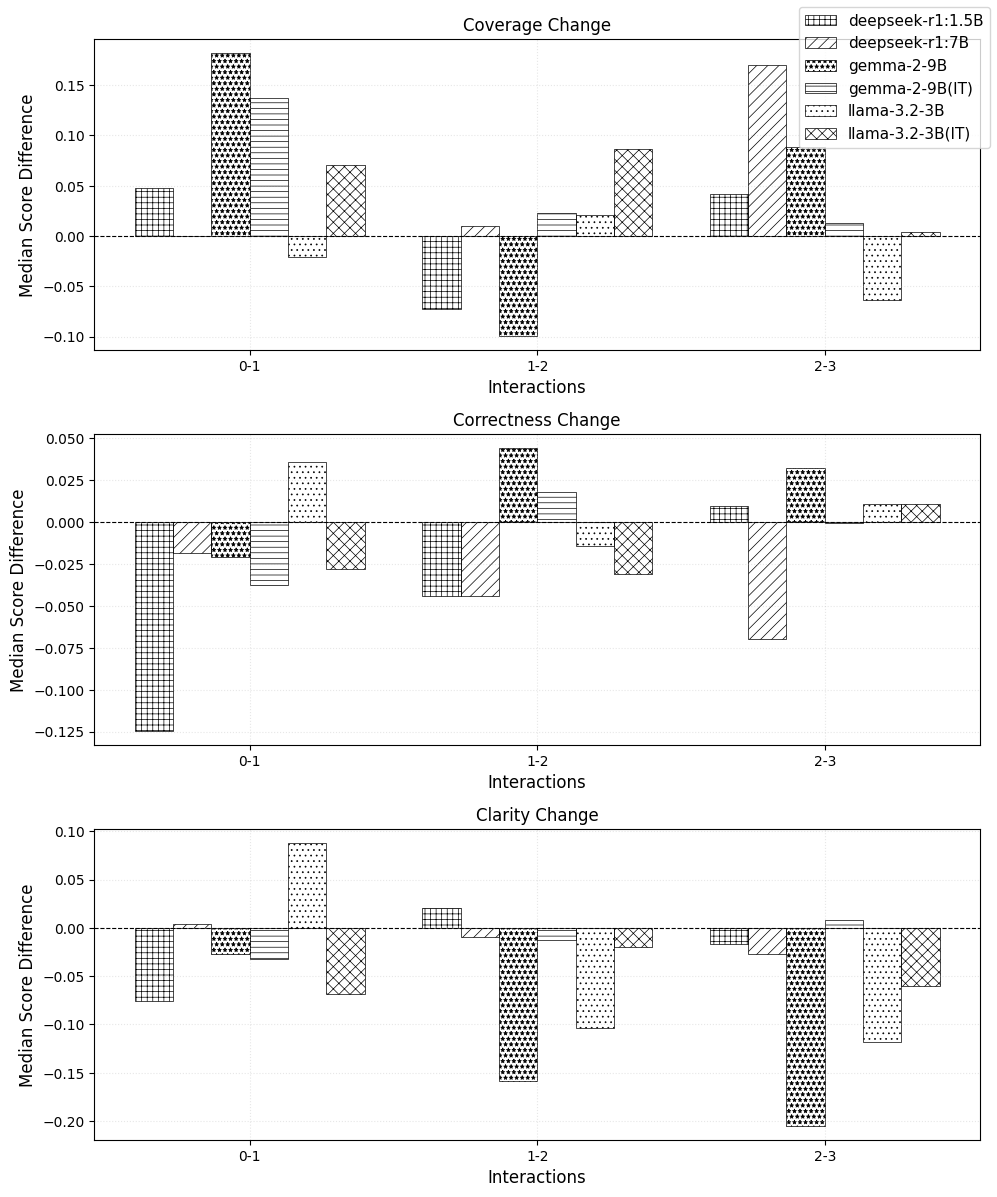

In [132]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

for i, metric in enumerate(['coverage', 'correctness', 'clarity']):
    metric_df = median_diff.pivot(index='trial_pair', columns='model', values=f'{metric}_diff')

    # Position bars side-by-side
    n_models = len(metric_df.columns)
    bar_width = 0.8 / n_models  # Dynamic width based on model count
    x_pos = np.arange(len(metric_df.index))  # Trial pairs (0-1, 1-2, etc.)

    for j, model in enumerate(metric_df.columns):
        axes[i].bar(
            x_pos + j * bar_width,  # Offset each model's bars
            metric_df[model],
            width=bar_width,
            label=model,
            hatch=model_hatches.get(model, '....'),  # Fallback to dots
            edgecolor='black',
            fill=False,  # No fill (pure patterns)
            linewidth=0.5  # Finer bar edges
        )

    # Formatting
    axes[i].set_title(f'{metric.capitalize()} Change', size=12)
    axes[i].axhline(0, color='black', linestyle='--', linewidth=0.8)
    axes[i].set_ylabel('Median Score Difference', size=12)
    axes[i].set_xlabel('Interactions', size=12)
    axes[i].set_xticks(x_pos + bar_width * (n_models - 1) / 2)  # Center labels
    axes[i].set_xticklabels(metric_df.index)
    #axes[i].legend(loc='lower right', fontsize=10)
    axes[i].grid(True, linestyle=':', alpha=0.3)

plt.tight_layout()
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, fontsize=11) #ncol=len(labels) , bbox_to_anchor=(0.5, 0.99)
plt.show()

### Average and Median covearge change between trials

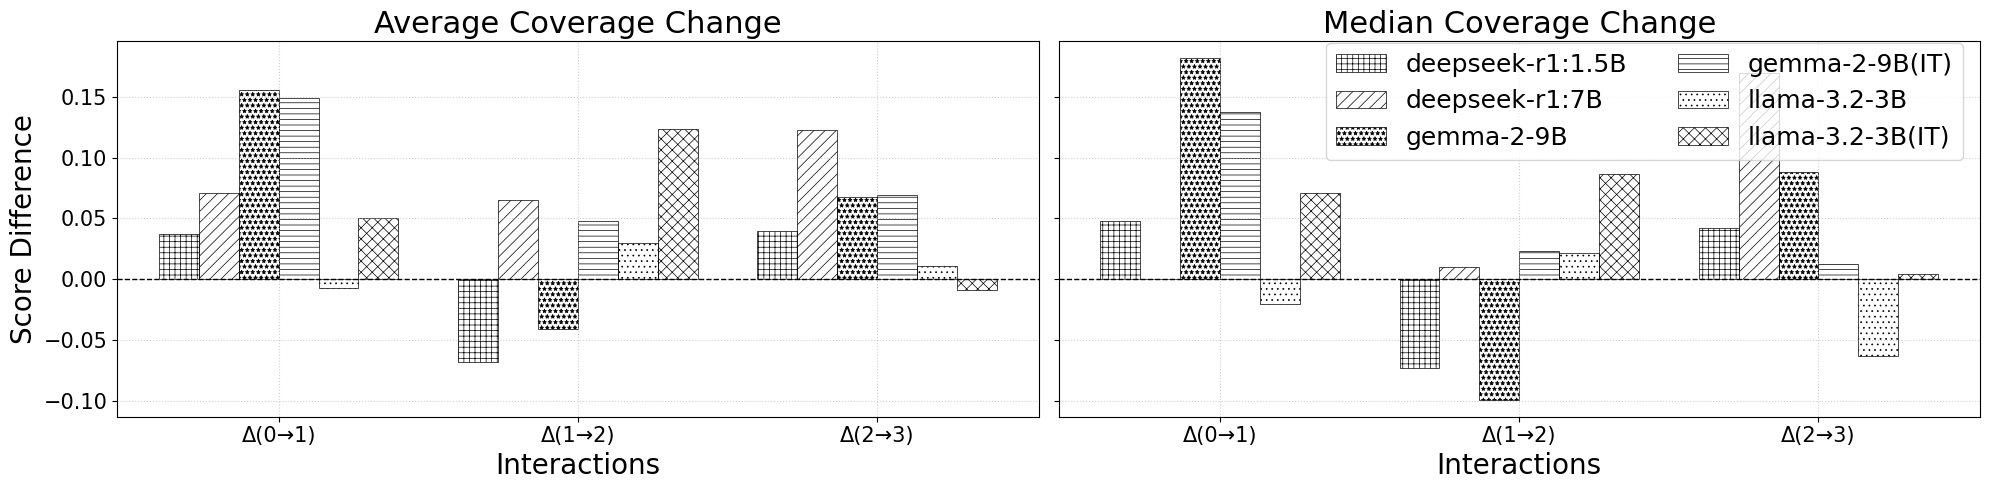

In [133]:
# Plotting both median and mean scores of coverage improvement
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=False, sharey=True)

# Plot Mean Differences
metric_df = mean_diff.pivot(index='trial_pair', columns='model', values='coverage_diff')
n_models = len(metric_df.columns)
bar_width = 0.8 / n_models
x_pos = np.arange(len(metric_df.index))

for j, model in enumerate(metric_df.columns):
    axes[0].bar(
        x_pos + j * bar_width,
        metric_df[model],
        width=bar_width,
        label=model,
        hatch=model_hatches.get(model, '....'),
        edgecolor='black',
        fill=False,
        linewidth=0.5
    )

axes[0].set_title('Average Coverage Change', size=22)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_ylabel('Score Difference', size=20)
axes[0].set_xlabel('Interactions', size=20)
axes[0].set_xticks(x_pos + bar_width * (n_models - 1) / 2)
axes[0].set_xticklabels([f"Δ({pair.replace('-', '→')})" for pair in metric_df.index])
#axes[0].set_xticklabels(metric_df.index)
axes[0].grid(True, linestyle=':', alpha=0.6)

# Plot Median Differences
metric_df = median_diff.pivot(index='trial_pair', columns='model', values='coverage_diff')

for j, model in enumerate(metric_df.columns):
    axes[1].bar(
        x_pos + j * bar_width,
        metric_df[model],
        width=bar_width,
        label=model,
        hatch=model_hatches.get(model, '....'),
        edgecolor='black',
        fill=False,
        linewidth=0.5
    )

axes[1].set_title('Median Coverage Change', size=22)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
#axes[1].set_ylabel('Score Difference', size=20)
axes[1].set_xlabel('Interactions', size=20)
axes[1].set_xticks(x_pos + bar_width * (n_models - 1) / 2)
axes[1].set_xticklabels([f"Δ({pair.replace('-', '→')})" for pair in metric_df.index])
#axes[1].set_xticklabels(metric_df.index)
axes[1].grid(True, linestyle=':', alpha=0.6)

# Add single legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.99, 0.93), fontsize=18, ncol=2)

# Increase tick label sizes
for ax in axes:
    ax.tick_params(axis='x', labelsize=15)  # Larger x-axis ticks
    ax.tick_params(axis='y', labelsize=15)  # Larger y-axis ticks

plt.rcParams['hatch.linewidth'] = 0.5  # Default=1.0 (thicker lines = more visible)
plt.tight_layout()
plt.show()

### Average covearge change between trials

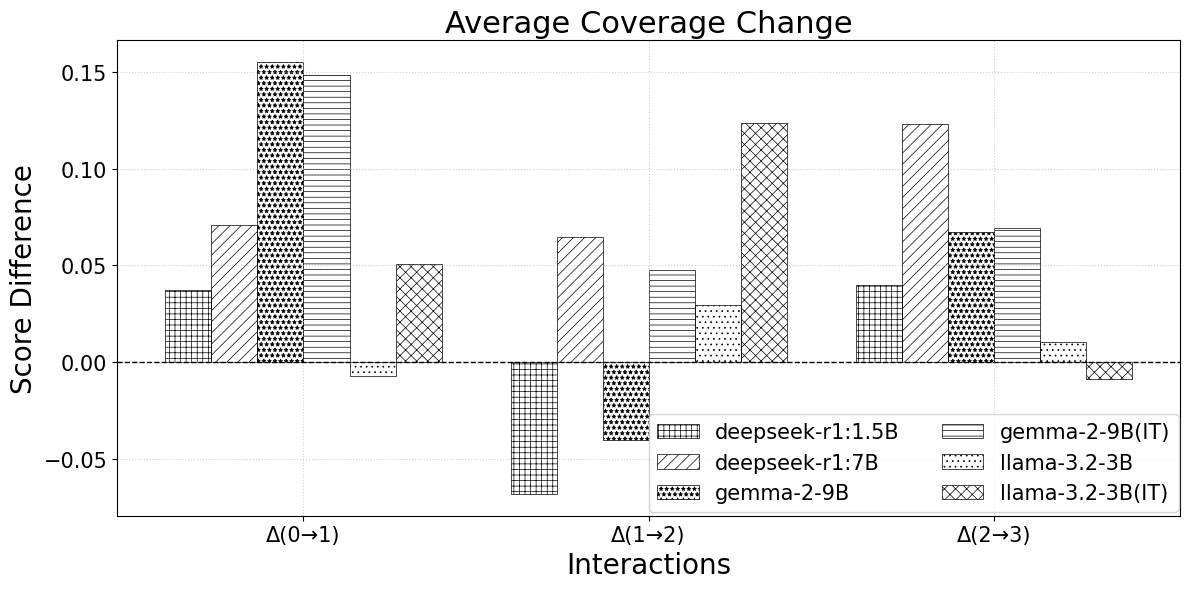

In [134]:
# Plotting mean scores of coverage improvement
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Mean Differences
metric_df = mean_diff.pivot(index='trial_pair', columns='model', values='coverage_diff')
n_models = len(metric_df.columns)
bar_width = 0.8 / n_models
x_pos = np.arange(len(metric_df.index))

for j, model in enumerate(metric_df.columns):
    ax.bar(
        x_pos + j * bar_width,
        metric_df[model],
        width=bar_width,
        label=model,
        hatch=model_hatches.get(model, '....'),
        edgecolor='black',
        fill=False,
        linewidth=0.5
    )

ax.set_title('Average Coverage Change', size=22)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_ylabel('Score Difference', size=20)
ax.set_xlabel('Interactions', size=20)
ax.set_xticks(x_pos + bar_width * (n_models - 1) / 2)
ax.set_xticklabels([f"Δ({pair.replace('-', '→')})" for pair in metric_df.index])
#ax.set_xticklabels(metric_df.index)
ax.grid(True, linestyle=':', alpha=0.6)

# Add single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.995, 0.12), fontsize=15, ncol=2)

# Increase tick label sizes
ax.tick_params(axis='x', labelsize=15)  # Larger x-axis ticks
ax.tick_params(axis='y', labelsize=15)  # Larger y-axis ticks

plt.rcParams['hatch.linewidth'] = 0.5  # Default=1.0 (thicker lines = more visible)
plt.tight_layout()
plt.show()

### Percentage Above Threshold between Trials

"What percentage of retried explanations met the quality threshold (0.6), per metric, after each interaction?"

In [202]:
# Step 1: Identify rows needing retry (any score < 0.6)
combined_df['needs_retry'] = (combined_df['coverage'] < 0.6) | \
                             (combined_df['correctness'] < 0.6) | \
                             (combined_df['clarity'] < 0.6)

# Step 2: Calculate percentage above threshold (0.6)
def calculate_percentage_above_threshold():
    results = []
    for model in combined_df['model'].unique():
        model_data = combined_df[combined_df['model'] == model]
        
        for prev_trial, current_trial in [(1,2), (2,3), (3,4)]:
            # Get previous trial data (only rows needing retry)
            prev_data = model_data[(model_data['trial'] == prev_trial-1) & 
                                 (model_data['needs_retry'])]
            
            # Get current trial data (all rows)
            current_data = model_data[model_data['trial'] == current_trial-1]
            
            # Calculate % above threshold for each metric
            def calc_pct_above(df):
                return {
                    'coverage_pct': (df['coverage'] >= 0.6).mean() * 100,
                    'correctness_pct': (df['correctness'] >= 0.6).mean() * 100,
                    'clarity_pct': (df['clarity'] >= 0.6).mean() * 100
                }
            
            prev_pct = calc_pct_above(prev_data)
            current_pct = calc_pct_above(current_data)
            
            # Calculate percentage point differences
            results.append({
                'model': model,
                'trial_pair': f"{prev_trial}-{current_trial}",
                'coverage_diff': current_pct['coverage_pct'] - prev_pct['coverage_pct'],
                'correctness_diff': current_pct['correctness_pct'] - prev_pct['correctness_pct'],
                'clarity_diff': current_pct['clarity_pct'] - prev_pct['clarity_pct'],
                'prev_coverage_pct': prev_pct['coverage_pct'],
                'current_coverage_pct': current_pct['coverage_pct'],
                'n_prev': len(prev_data),
                'n_current': len(current_data)
            })
    return pd.DataFrame(results)

In [203]:
# Get the percentage improvements
pct_diff = calculate_percentage_above_threshold()

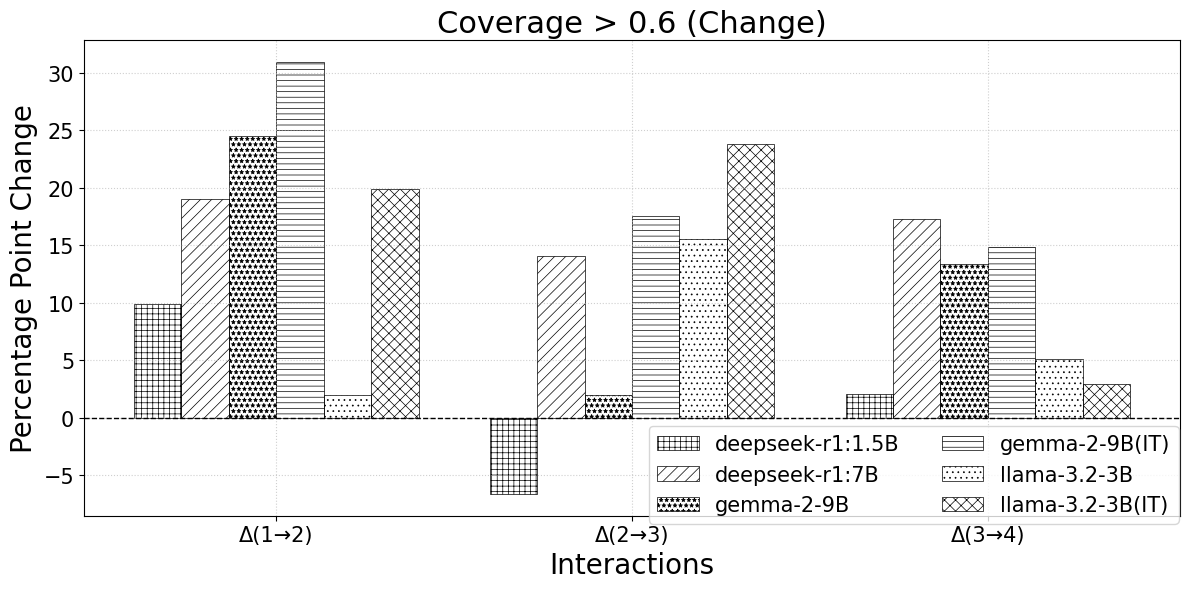

In [204]:
# Plotting mean scores of coverage improvement
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Mean Differences
metric_df = pct_diff.pivot(index='trial_pair', columns='model', values='coverage_diff')
n_models = len(metric_df.columns)
bar_width = 0.8 / n_models
x_pos = np.arange(len(metric_df.index))

for j, model in enumerate(metric_df.columns):
    ax.bar(
        x_pos + j * bar_width,
        metric_df[model],
        width=bar_width,
        label=model,
        hatch=model_hatches.get(model, '....'),
        edgecolor='black',
        fill=False,
        linewidth=0.5
    )

ax.set_title('Coverage > 0.6 (Change)', size=22)
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_ylabel('Percentage Point Change', size=20)
ax.set_xlabel('Interactions', size=20)
ax.set_xticks(x_pos + bar_width * (n_models - 1) / 2)
ax.set_xticklabels([f"Δ({pair.replace('-', '→')})" for pair in metric_df.index])
#ax.set_xticklabels(metric_df.index)
ax.grid(True, linestyle=':', alpha=0.6)

# Add single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.995, 0.10), fontsize=15, ncol=2)

# Increase tick label sizes
ax.tick_params(axis='x', labelsize=15)  # Larger x-axis ticks
ax.tick_params(axis='y', labelsize=15)  # Larger y-axis ticks

plt.rcParams['hatch.linewidth'] = 0.5  # Default=1.0 (thicker lines = more visible)
plt.tight_layout()
plt.show()

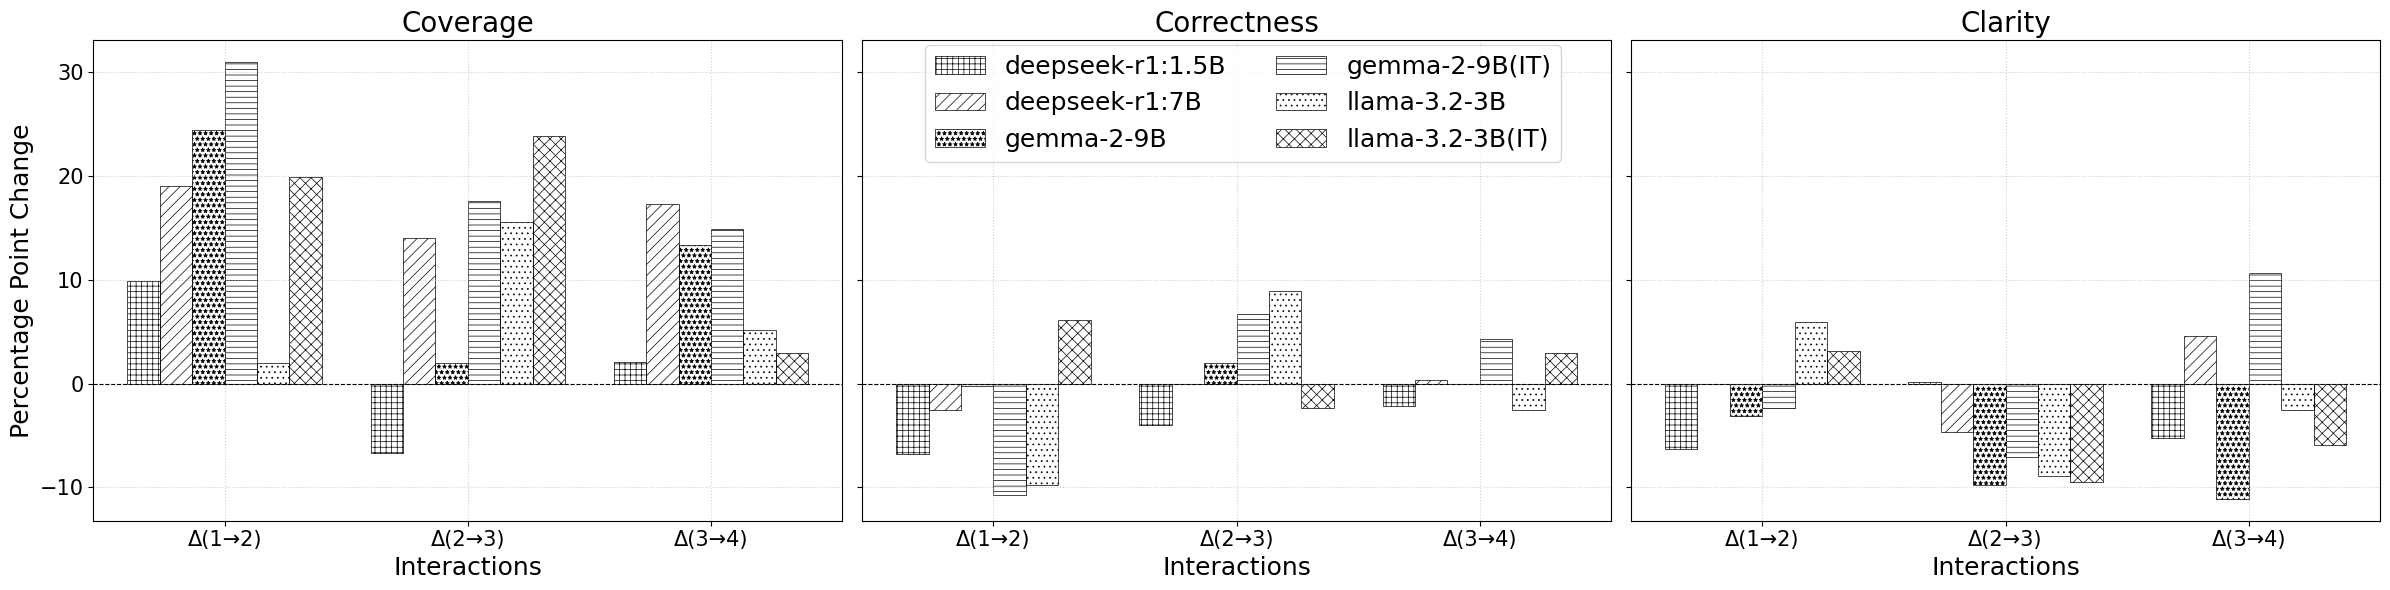

In [205]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

for i, metric in enumerate(['coverage', 'correctness', 'clarity']):
    metric_df = pct_diff.pivot(index='trial_pair', columns='model', values=f'{metric}_diff')

    # Position bars side-by-side
    n_models = len(metric_df.columns)
    bar_width = 0.8 / n_models  # Dynamic width based on model count
    x_pos = np.arange(len(metric_df.index))  # Trial pairs (0-1, 1-2, etc.)

    for j, model in enumerate(metric_df.columns):
        axes[i].bar(
            x_pos + j * bar_width,  # Offset each model's bars
            metric_df[model],
            width=bar_width,
            label=model,
            hatch=model_hatches.get(model, '....'),  # Fallback to dots
            edgecolor='black',
            fill=False,  # No fill (pure patterns)
            linewidth=0.5  # Finer bar edges
        )

    # Formatting
    axes[i].set_title(f'{metric.capitalize()}', size=20) # > 0.6 (Change)
    axes[i].axhline(0, color='black', linestyle='--', linewidth=0.8)
    if i == 0:
        axes[i].set_ylabel('Percentage Point Change', size=18)
    axes[i].set_xlabel('Interactions', size=18)
    axes[i].set_xticks(x_pos + bar_width * (n_models - 1) / 2)  # Center labels
    axes[i].set_xticklabels([f"Δ({pair.replace('-', '→')})" for pair in metric_df.index])

    axes[i].grid(True, linestyle=':', alpha=0.6)

# Increase tick label sizes
for ax in axes:
    ax.tick_params(axis='x', labelsize=15)  # Larger x-axis ticks
    ax.tick_params(axis='y', labelsize=15)  # Larger y-axis ticks

plt.rcParams['hatch.linewidth'] = 0.5 
plt.tight_layout()
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=2, fontsize=18, bbox_to_anchor=(0.52, 0.82)) #ncol=len(labels) 
plt.show()

## Summary Statistics

### Stats by trial

In [41]:
def get_statistical_summaries(df, columns_to_analyze=None):
    """
    Generates statistical summaries (mean, median, std, min, max, etc.)
    for specified metrics across models and trials.

    Args:
        df (pd.DataFrame): Combined DataFrame with 'model', 'trial', and metrics.
        columns_to_analyze (list): List of columns to analyze. If None, uses all numeric columns.

    Returns:
        pd.DataFrame: Summary statistics per model and trial.
    """
    if columns_to_analyze is None:
        # If no columns specified, use all numeric columns (excluding 'trial')
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        columns_to_analyze = [col for col in numeric_cols if col != 'trial']

    # Group by model and trial, then compute statistics
    grouped = df.groupby(['model', 'trial'])[columns_to_analyze]

    # Define summary statistics
    stats = grouped.agg(
        ['mean', 'median', 'std', 'count'] #'min', 'max',
    ).round(3)

    # Flatten MultiIndex columns for readability
    stats.columns = [
        f"{col}_{stat}"
        for col, stat in stats.columns
    ]

    return stats

In [42]:
summary_stats = get_statistical_summaries(combined_df, columns_to_analyze)

In [43]:
summary_stats

coverage_mean  coverage_median  coverage_std  \
model            trial                                                 
deepseek-r1:1.5B 0              0.279            0.184         0.240   
                 1              0.283            0.213         0.244   
                 2              0.192            0.117         0.186   
                 3              0.228            0.159         0.216   
deepseek-r1:7B   0              0.492            0.470         0.323   
                 1              0.358            0.263         0.295   
                 2              0.313            0.184         0.270   
                 3              0.370            0.318         0.260   
gemma-2-9B       0              0.532            0.583         0.321   
                 1              0.479            0.445         0.295   
                 2              0.325            0.235         0.253   
                 3              0.333            0.261         0.244   
gemma-2-9B(IT)   0              0.460            0.419         0.289   
                 1              0.448            0.441         0.280   
                 2              0.344            0.273         0.231   
                 3              0.334            0.247         0.255   
llama-3.2-3B     0              0.676            0.748         0.274   
                 1              0.450            0.438         0.283   
                 2              0.436            0.373         0.292   
                 3              0.400            0.287         0.312   
llama-3.2-3B(IT) 0              0.610            0.684         0.281   
                 1              0.449            0.482         0.259   
                 2              0.445            0.373         0.280   
                 3              0.345            0.326         0.271   

                        coverage_count  completness_mean  completness_median  \
model            trial                                                         
deepseek-r1:1.5B 0                 121             0.239               0.166   
                 1                 112             0.249               0.161   
                 2                 107             0.167               0.106   
                 3                 103             0.203               0.123   
deepseek-r1:7B   0                 124             0.418               0.355   
                 1                  79             0.292               0.224   
                 2                  64             0.260               0.164   
                 3                  53             0.301               0.237   
gemma-2-9B       0                 120             0.453               0.404   
                 1                  70             0.406               0.351   
                 2                  51             0.274               0.203   
                 3                  45             0.277               0.210   
gemma-2-9B(IT)   0                 120             0.367               0.320   
                 1                  84             0.383               0.372   
                 2                  57             0.300               0.264   
                 3                  47             0.293               0.213   
llama-3.2-3B     0                 120             0.582               0.620   
                 1                  51             0.395               0.318   
                 2                  45             0.376               0.299   
                 3                  39             0.349               0.264   
llama-3.2-3B(IT) 0                 121             0.520               0.529   
                 1                  61             0.371               0.302   
                 2                  42             0.358               0.292   
                 3                  34             0.279               0.221   

                        completness_std  completness_count  correctnes

### Stats of zero shot (Trial 0)

In [199]:
def get_statistical_summaries2(df, columns_to_analyze=None):
    if columns_to_analyze is None:
        # If no columns specified, use all numeric columns (excluding 'trial')
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        columns_to_analyze = [col for col in numeric_cols if col != 'trial']

    # Group by model and trial, then compute statistics
    df = df[df['trial'] == 0]

    grouped = df.groupby(['model'])[columns_to_analyze]

    # Define summary statistics
    stats = grouped.agg(
        ['mean', 'median', 'std', 'min', 'max', 'count'] #   
    ).round(2)

    # Flatten MultiIndex columns for readability
    #stats.columns = [
    #    f"{col}_{stat}"
    #    for col, stat in stats.columns
    #]

    return stats

In [200]:
summary_stats2 = get_statistical_summaries2(combined_df, columns_to_analyze)

In [201]:
summary_stats2

coverage                                completness         \
                     mean median   std   min   max count        mean median   
model                                                                         
deepseek-r1:1.5B     0.28   0.18  0.24  0.04  0.97   121        0.24   0.17   
deepseek-r1:7B       0.49   0.47  0.32  0.02  0.99   124        0.42   0.35   
gemma-2-9B           0.53   0.58  0.32  0.04  0.99   120        0.45   0.40   
gemma-2-9B(IT)       0.46   0.42  0.29  0.05  0.99   120        0.37   0.32   
llama-3.2-3B         0.68   0.75  0.27  0.06  0.99   120        0.58   0.62   
llama-3.2-3B(IT)     0.61   0.68  0.28  0.04  0.98   121        0.52   0.53   

                                         correctness                           \
                   std   min   max count        mean median   std   min   max   
model                                                                           
deepseek-r1:1.5B  0.22  0.04  0.88   121        0.56   0.51  0.32  0.04  0.99   
deepseek-r1:7B    0.30  0.02  0.99   124        0.86   0.97  0.24  0.05  0.99   
gemma-2-9B        0.29  0.04  0.99   120        0.89   0.96  0.16  0.17  0.99   
gemma-2-9B(IT)    0.24  0.05  0.99   120        0.92   0.96  0.11  0.28  0.99   
llama-3.2-3B      0.27  0.06  0.99   120        0.87   0.94  0.18  0.16  0.99   
llama-3.2-3B(IT)  0.27  0.04  0.98   121        0.84   0.96  0.24  0.13  0.99   

                       clarity                                hallucination  \
                 count    mean median   std   min   max count          mean   
model                                                                         
deepseek-r1:1.5B   121    0.88   0.96  0.19  0.10  0.99   121          0.18   
deepseek-r1:7B     124    0.86   0.93  0.20  0.03  0.99   124          0.26   
gemma-2-9B         120    0.84   0.92  0.22  0.09  0.99   120          0.35   
gemma-2-9B(IT)     120    0.92   0.94  0.07  0.58  0.99   120          0.38   
llama-3.2-3B       120    0.75   0.79  0.17  0.04  0.98   120          0.46   
llama-3.2-3B(IT)   121    0.94   0.98  0.12  0.24  0.99   121          0.20   

                                                grammar_score               \
                 median   std   min   max count          mean median   std   
model                                                                        
deepseek-r1:1.5B   0.07  0.22  0.00  0.96   121          0.98   0.98  0.02   
deepseek-r1:7B     0.13  0.28  0.01  0.96   124          0.95   0.96  0.04   
gemma-2-9B         0.27  0.30  0.00  0.98   120          0.97   0.98  0.03   
gemma-2-9B(IT)     0.26  0.30  0.01  0.97   120          0.95   0.95  0.03   
llama-3.2-3B       0.46  0.30  0.01  0.97   120          0.90   0.94  0.11   
llama-3.2-3B(IT)   0.11  0.22  0.01  0.89   121          0.94   0.97  0.11   

                                    
                   min   max count  
model                               
deepseek-r1:1.5B  0.92  1.00   121  
deepseek-r1:7B    0.78  1.00   124  
gemma-2-9B        0.82  1.00   120  
gemma-2-9B(IT)    0.82  0.99   120  
llama-3.2-3B      0.28  1.00   120  
llama-3.2-3B(IT)  0.28  1.00   121

In [196]:
# Group by model and trial
zero_df = combined_df[combined_df['trial'] == 0]
more_columns = columns_to_analyze + ["prompt_size", "answer_size"]
grouped = zero_df.groupby(['model'])[more_columns]
mean_scores = grouped.mean().round(2)
median_scores = grouped.median().round(2)

In [197]:
mean_scores

,coverage,completness,correctness,clarity,hallucination,grammar_score,prompt_size,answer_size
model,,,,,,,,
deepseek-r1:1.5B,0.28,0.24,0.56,0.88,0.18,0.98,1237.26,523.31
deepseek-r1:7B,0.49,0.42,0.86,0.86,0.26,0.95,1286.85,351.09
gemma-2-9B,0.53,0.45,0.89,0.84,0.35,0.97,1268.72,343.78
gemma-2-9B(IT),0.46,0.37,0.92,0.92,0.38,0.95,1236.79,356.36
llama-3.2-3B,0.68,0.58,0.87,0.75,0.46,0.90,1242.42,328.84
llama-3.2-3B(IT),0.61,0.52,0.84,0.94,0.20,0.94,1246.17,430.36


In [198]:
median_scores

,coverage,completness,correctness,clarity,hallucination,grammar_score,prompt_size,answer_size
model,,,,,,,,
deepseek-r1:1.5B,0.18,0.17,0.51,0.96,0.07,0.98,1100.0,254.0
deepseek-r1:7B,0.47,0.35,0.97,0.93,0.13,0.96,1123.0,250.0
gemma-2-9B,0.58,0.40,0.96,0.92,0.27,0.98,1130.5,291.5
gemma-2-9B(IT),0.42,0.32,0.96,0.94,0.26,0.95,1115.0,358.0
llama-3.2-3B,0.75,0.62,0.94,0.79,0.46,0.94,1104.5,281.0
llama-3.2-3B(IT),0.68,0.53,0.96,0.98,0.11,0.97,1109.0,341.0


## Stats of few-shot experiment 

In [177]:
file_paths_new = [
    "results/few_shot_output_DeepSeek-R1-Distill-Qwen-1.5B_updated.csv",
    "results/few_shot_output_DeepSeek-R1-Distill-Qwen-7B_updated.csv",
    "results/few_shot_output_Llama-3.2-3B-Instruct_updated.csv",
    "results/few_shot_output_Llama-3.2-3B_updated.csv",
    "results/few_shot_output_gemma-2-9b-it_updated.csv",
    "results/few_shot_output_gemma-2-9b_updated.csv"
]

In [178]:
# using an alias for models
model_names = {
	"DeepSeek-R1-Distill-Qwen-1.5B" : "deepseek-r1:1.5B",
	"DeepSeek-R1-Distill-Qwen-7B" : "deepseek-r1:7B",
	"Llama-3.2-3B" : "llama-3.2-3B",
	"Llama-3.2-3B-Instruct" : "llama-3.2-3B(IT)",
	"gemma-2-9b" : "gemma-2-9B",
	"gemma-2-9b-it" : "gemma-2-9B(IT)",
}

In [179]:
# Create an empty list to store DataFrames
dfs_new = []

for file_path in file_paths_new:
    # Read the CSV file
    df = pd.read_csv(file_path, sep=";", header=0)

    # Extract model name from filename (remove path, 'output_' prefix, and .csv extension)
    model_name = os.path.basename(file_path).replace('few_shot_output_', '').replace('.csv', '').replace('_updated', '')

    # Add model column
    df['model'] = model_names[model_name]

    # Append to list
    dfs_new.append(df)

# Concatenate all DataFrames
combined_df_new = pd.concat(dfs_new, ignore_index=True)

In [180]:
combined_df_new.head(1)

,subject,action,obj,outcome,decision,logical_explanations,prompt_text,prompt_size,answer_size,answer,combined_score,coverage,completness,correctness,clarity,hallucination,grammar_score,flesch_reading_ease,flesch_kincaid_grade,gunning_fog,smog_index,coleman_liau_index,ari,model
0,Dylan_Nelson,move,dataset3,True,**The Decision:** The outcome of the logical i...,"(researcher, audit) > (PhD_student, collaborat...",This is an example case for illustration purpo...,2214,464,\n\n### Structured Explanation\n\n**Decision R...,0.488993,0.620178,0.556234,0.640137,0.547852,0.919434,0.952542,6.3,15.9,12.58,15.9,21.39,20.0,deepseek-r1:1.5B


In [181]:
columns_to_analyze = ['coverage', 'completness', 'correctness', 'clarity', 'hallucination', 'grammar_score',]

In [216]:
def get_statistical_summaries2_new(df, columns_to_analyze=None):
    if columns_to_analyze is None:
        # If no columns specified, use all numeric columns (excluding 'trial')
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        columns_to_analyze = [col for col in numeric_cols if col != 'trial']

    grouped = df.groupby(['model'])[columns_to_analyze]

    # Define summary statistics
    stats = grouped.agg(
        ['mean', 'median', 'std', 'min', 'max', 'count'] #  
    ).round(2)

    # Flatten MultiIndex columns for readability
    #stats.columns = [
    #    f"{col}_{stat}"
    #    for col, stat in stats.columns
    #]

    return stats

In [217]:
summary_stats2_new = get_statistical_summaries2_new(combined_df_new, columns_to_analyze)

In [218]:
summary_stats2_new

coverage                                completness         \
                     mean median   std   min   max count        mean median   
model                                                                         
deepseek-r1:1.5B     0.22   0.14  0.21  0.02  0.98   118        0.19   0.13   
deepseek-r1:7B       0.51   0.56  0.31  0.03  0.99    87        0.44   0.41   
gemma-2-9B           0.45   0.38  0.27  0.03  0.97   106        0.37   0.33   
gemma-2-9B(IT)       0.65   0.73  0.29  0.10  0.99   119        0.58   0.62   
llama-3.2-3B         0.31   0.20  0.29  0.03  0.98   119        0.27   0.20   
llama-3.2-3B(IT)     0.59   0.64  0.28  0.04  0.99   119        0.50   0.49   

                                         correctness                           \
                   std   min   max count        mean median   std   min   max   
model                                                                           
deepseek-r1:1.5B  0.18  0.02  0.94   118        0.46   0.34  0.29  0.09  0.99   
deepseek-r1:7B    0.29  0.03  0.99    87        0.69   0.84  0.31  0.11  0.99   
gemma-2-9B        0.23  0.03  0.95   106        0.75   0.86  0.26  0.08  0.99   
gemma-2-9B(IT)    0.28  0.09  0.99   119        0.94   0.97  0.11  0.16  0.99   
llama-3.2-3B      0.25  0.03  0.97   119        0.59   0.65  0.31  0.10  0.98   
llama-3.2-3B(IT)  0.25  0.04  0.99   119        0.89   0.96  0.17  0.07  0.99   

                       clarity                                hallucination  \
                 count    mean median   std   min   max count          mean   
model                                                                         
deepseek-r1:1.5B   118    0.85   0.96  0.25  0.05  0.99   118          0.17   
deepseek-r1:7B      87    0.87   0.94  0.21  0.10  0.99    87          0.29   
gemma-2-9B         106    0.84   0.88  0.16  0.03  0.98   106          0.37   
gemma-2-9B(IT)     119    0.88   0.91  0.13  0.19  0.98   119          0.33   
llama-3.2-3B       119    0.65   0.75  0.32  0.02  1.00   119          0.42   
llama-3.2-3B(IT)   119    0.86   0.95  0.21  0.07  0.99   119          0.37   

                                                grammar_score               \
                 median   std   min   max count          mean median   std   
model                                                                        
deepseek-r1:1.5B   0.10  0.17  0.01  0.92   118          0.97   0.98  0.04   
deepseek-r1:7B     0.19  0.27  0.01  0.97    87          0.93   0.95  0.06   
gemma-2-9B         0.27  0.30  0.01  0.99   106          0.98   0.99  0.03   
gemma-2-9B(IT)     0.26  0.24  0.01  0.94   119          0.95   0.95  0.03   
llama-3.2-3B       0.42  0.26  0.03  0.99   119          0.95   0.98  0.11   
llama-3.2-3B(IT)   0.34  0.26  0.02  0.93   119          0.90   0.94  0.12   

                                   
                   min  max count  
model                              
deepseek-r1:1.5B  0.70  1.0   118  
deepseek-r1:7B    0.57  1.0    87  
gemma-2-9B        0.79  1.0   106  
gemma-2-9B(IT)    0.86  1.0   119  
llama-3.2-3B      0.03  1.0   119  
llama-3.2-3B(IT)  0.32  1.0   119

In [214]:
# Group by model
more_columns = columns_to_analyze + ["prompt_size", "answer_size"]
grouped_new = combined_df_new.groupby(['model'])[more_columns]
mean_scores_new = grouped_new.mean().round(2)
median_scores_new = grouped_new.median().round(2)

In [215]:
mean_scores_new

,coverage,completness,correctness,clarity,hallucination,grammar_score,prompt_size,answer_size
model,,,,,,,,
deepseek-r1:1.5B,0.22,0.19,0.46,0.85,0.17,0.97,2067.26,544.08
deepseek-r1:7B,0.51,0.44,0.69,0.87,0.29,0.93,2049.72,332.64
gemma-2-9B,0.45,0.37,0.75,0.84,0.37,0.98,2125.40,518.08
gemma-2-9B(IT),0.65,0.58,0.94,0.88,0.33,0.95,2111.30,388.81
llama-3.2-3B,0.31,0.27,0.59,0.65,0.42,0.95,2063.11,370.63
llama-3.2-3B(IT),0.59,0.50,0.89,0.86,0.37,0.90,2063.11,541.43


In [189]:
median_scores_new

,coverage,completness,correctness,clarity,hallucination,grammar_score
model,,,,,,
deepseek-r1:1.5B,0.14,0.13,0.34,0.96,0.10,0.98
deepseek-r1:7B,0.56,0.41,0.84,0.94,0.19,0.95
gemma-2-9B,0.38,0.33,0.86,0.88,0.27,0.99
gemma-2-9B(IT),0.73,0.62,0.97,0.91,0.26,0.95
llama-3.2-3B,0.20,0.20,0.65,0.75,0.42,0.98
llama-3.2-3B(IT),0.64,0.49,0.96,0.95,0.34,0.94


In [155]:
mean_scores

,coverage,completness,correctness,clarity,hallucination,grammar_score
model,,,,,,
deepseek-r1:1.5B,0.28,0.24,0.56,0.88,0.18,0.98
deepseek-r1:7B,0.49,0.42,0.86,0.86,0.26,0.95
gemma-2-9B,0.53,0.45,0.89,0.84,0.35,0.97
gemma-2-9B(IT),0.46,0.37,0.92,0.92,0.38,0.95
llama-3.2-3B,0.68,0.58,0.87,0.75,0.46,0.90
llama-3.2-3B(IT),0.61,0.52,0.84,0.94,0.20,0.94


In [160]:
mean_scores = mean_scores[mean_scores['coverage'] != 0.28]

In [172]:
fewer_columns = ['coverage', 'correctness', 'clarity'] #, 'hallucination',
mean_scores = mean_scores[fewer_columns]
mean_scores_new = mean_scores_new[fewer_columns]

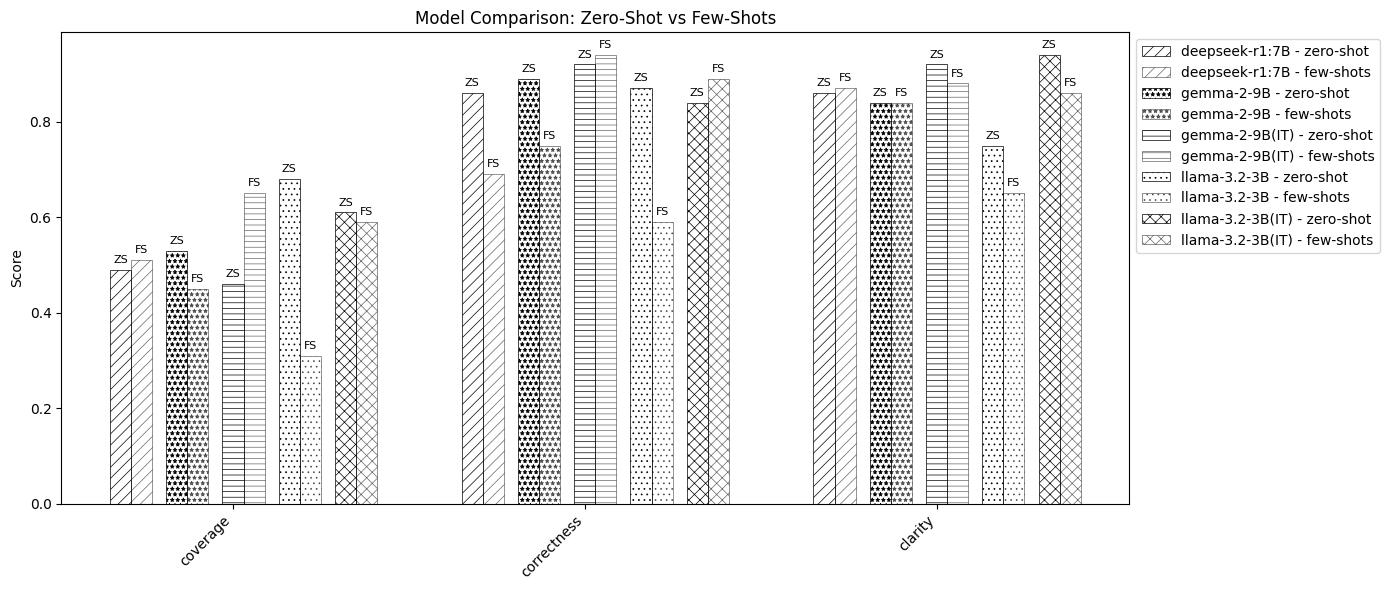

In [176]:
metrics = mean_scores.columns
models = mean_scores.index
num_models = len(models)

x = np.arange(len(metrics)) * 2.5  # spacing between metric groups
bar_width = 0.15
gap = 0.1  # space between model bar groups within the metric

fig, ax = plt.subplots(figsize=(14, 6))

for m_idx, model in enumerate(models):
    offset = m_idx * (2 * bar_width + gap)  # add gap between model groups

    # Bar positions for this model
    x_zero = x + offset
    x_few = x + offset + bar_width

    # Plot zero-shot
    bar1 = ax.bar(x_zero, mean_scores.loc[model], bar_width,
                  label=f'{model} - zero-shot',
                  hatch=model_hatches.get(model, '....'),
                  edgecolor='black', fill=False, linewidth=0.5)

    # Plot few-shot
    bar2 = ax.bar(x_few, mean_scores_new.loc[model], bar_width,
                  label=f'{model} - few-shots',
                  hatch=model_hatches.get(model, '....'),
                  edgecolor='black', fill=False, linewidth=0.5, alpha=0.6)

    # Add top labels
    for rect in bar1:
        ax.text(rect.get_x() + bar_width / 2, rect.get_height() + 0.01, 'ZS',
                ha='center', va='bottom', fontsize=8)
    for rect in bar2:
        ax.text(rect.get_x() + bar_width / 2, rect.get_height() + 0.01, 'FS',
                ha='center', va='bottom', fontsize=8)

# Setup x-axis
total_group_width = num_models * (2 * bar_width + gap)
ax.set_xticks(x + total_group_width / 2 - (bar_width + gap / 2))
ax.set_xticklabels(metrics, rotation=45, ha='right')

ax.set_ylabel('Score')
ax.set_title('Model Comparison: Zero-Shot vs Few-Shots')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## More

In [ ]:
# Function to reverse and normalize readability scores
def normalize_and_combine(df):
    # Reverse Flesch Reading Ease (FRE)
    df['Reversed_FRE'] = 100 - df['flesch_reading_ease']

    # Normalize Flesch-Kincaid Grade (FKG) to 0-100 scale (assuming range 1-12)
    df['Normalized_FKG'] = ((df['flesch_kincaid_grade'] - 1) / 11) * 100

    # Normalize Gunning Fog Index (GFI) to 0-100 scale (assuming range 5-20)
    df['Normalized_GFI'] = ((df['gunning_fog'] - 5) / 15) * 100

    # Normalize SMOG Index to 0-100 scale (assuming range 5-20)
    df['Normalized_SMOG'] = ((df['smog_index'] - 5) / 15) * 100

    # Normalize Coleman-Liau Index (CLI) to 0-100 scale (assuming range 2-12)
    df['Normalized_CLI'] = ((df['coleman_liau_index'] - 2) / 10) * 100

    # Normalize ARI to 0-100 scale (assuming range 1-14)
    df['Normalized_ARI'] = ((df['ari'] - 1) / 13) * 100

    # Calculate the combined readability score by averaging the normalized values
    df['Combined_Score'] = (df['Reversed_FRE'] + df['Normalized_FKG'] + df['Normalized_GFI'] + df['Normalized_SMOG'] + df['Normalized_CLI'] + df['Normalized_ARI']) / 6

    return df